# MLP Project - Predict the Success of Bank Telemarketing

## Project Overview
We aim to develop models capable of accurately predicting the success of bank telemarketing based on this dataset.


## Dataset Description
The data is related with direct marketing campaigns of a banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

## Input variables:
- last contact date: last contact date
- age (numeric)
- job: type of job
- marital: marital status (categorical: "married", "divorced", "single"; note: "divorced" means divorced or widowed)
- education (categorical: "unknown", "secondary", "primary", "tertiary")
- default: has credit in default? (binary: "yes", "no")
- balance: average yearly balance, in euros (numeric)
- housing: has housing loan? (binary: "yes", "no")
- loan: has a personal loan? (binary: "yes", "no")
- contact: contact communication type (categorical: "unknown", "telephone", "cellular")
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Imports Important Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Import necessary libraries for models 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Skip Random Warnings
import warnings
warnings.filterwarnings('ignore')

# Loads The Dataset

In [4]:
train_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
sample_submission=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")

### There are 3 files:

*   train.csv
*   test.csv
*   sample_submission

All three files into pandas DataFrames: train_data, test_data, and sample_submission.

# Basic Exploration

In [5]:
train_data.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

# Data Understanding
**Objective**: Predict whether a client will subscribe to a term deposit ('yes' or 'no') based on the provided features.

**Features Description**:

**last contact date**: The date of the last contact.

**age**: Age of the client.

**job**: Type of job (e.g., admin., technician, blue-collar).

**marital**: Marital status (e.g., single, married, divorced).

**education**: Education level (e.g., primary, secondary, tertiary).

**default**: Has credit in default? ('yes' or 'no').

**balance**: Balance of the individual.

**housing**: Has a housing loan? ('yes' or 'no').

**loan**: Has a personal loan? ('yes' or 'no').

**contact**: Contact communication type (e.g., cellular, telephone).

**duration**: Last contact duration, in seconds.

**campaign**: Number of contacts performed during this campaign.

**pdays**: Days since the client was last contacted from a previous campaign.

**previous**: Number of contacts performed before this campaign.

**poutcome**: Outcome of the previous marketing campaign.

**target**: The target variable ('yes' or 'no') indicating subscription.

# EDA & Visualization

In [6]:
#Display basic information and the first few rows of train dataset
train_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


### Initial Data Preview (`head()`)

Here is a quick summary of the first few rows of the dataset:

1. The dataset contains columns like `last contact date`, `age`, `job`, `marital` etc., which represent the personal life of person with his/her banking data and campaigns for bank deposits.
2. Data:
   - `Column1` seems to be last day on which contact made to the person by the bank.
   - `Column2 - Column5` contains personal information with some missing values (`NaN`).
   - `Column6 - Column10` appears to hold Banking information such as loan status, contact type and defaulter status.
   - `Column11 - Column15` appears to hold campaigns data for the person by the bank.
   - `Column16` reprsents the campaign suceess information as `yes` or `no`.
3. Observed patterns:
   - `Column16` has only `yes` and `no` values, indicating it is a `Binary Classification` problem.
   
**Action Points**:
- Investigate the data types further for accuracy.

In [7]:
#Display basic information and the first few rows of test dataset
test_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


### Initial Data Preview (`head()`)

Here is a quick summary of the first few rows of the dataset:

1. The dataset contains columns like `last contact date`, `age`, `job`, `marital` etc., which represent the personal life of person with his/her banking data and campaigns for bank deposits.
2. Data:
   - `Column1` seems to be last day on which contact made to the person by the bank.
   - `Column2 - Column5` contains personal information with some missing values (`NaN`).
   - `Column6 - Column10` appears to hold Banking information such as loan status, contact type and defaulter status.
   - `Column11 - Column15` appears to hold campaigns data for the person by the bank.
   
**Action Points**:
- Investigate the data types further for accuracy.

In [8]:
# this is how submission will look Like

sample_submission

,id,target
0,0,no
1,1,no
2,2,no
3,3,yes
4,4,yes
...,...,...
9995,9995,yes
9996,9996,no
9997,9997,no
9998,9998,no


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [10]:
# checks for missing values using isnull().sum().
train_data.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

## Dataset Overview

The dataset structure and key insights based on the `info()` output are as follows:

1. **Total Entries (Rows)**: The dataset contains  **39211 rows**.
2. **Total Columns**: There are **16 columns** in the dataset.
3. **Data Types**:
   - **Integer (`int64`)**: 6 column
   - **Float (`float64`)**: 0 column
   - **Object (`object`)**: 10 column
   - **Boolean (`bool`)**: 0 column
4. **Missing Values**:
   - `Column3` has **229 missing values**.
   - `Column5` has **1467 missing values**.
   - `Column10` has **10336 missing values**.
   - `Column15` has **29451 missing values**.
5. **Memory Usage**: The dataset uses approximately **4.8 MB** of memory.

### Additional Observations
- Other Columns have no missing values, ensuring their reliability.
-  ### Numerical Column Characteristics
Age is an integer, likely representing customer ages
Balance shows financial information
Duration might represent call/interaction length
Campaign likely indicates marketing campaign interactions
Pdays and previous columns possibly track previous contact history

- ### Categorical Column Insights
Target column suggests this is a classification dataset (predicting customer response)
Multiple categorical variables related to customer demographics and banking status

### Suggestions for Data Preparation
- Handle missing values in `Column3`, `Column5`, `Column10` and `Column15` before proceeding with training.
- Verify the data types for correctness, especially for `object` and `category` columns.
- Explore the categorical distributions in `object` columns to understand its significance.

In [11]:
# Summary statistics for numerical features
train_data.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


## Statistical Summary (`describe()`)

### Key Observations:
1. **Summary of Numerical Columns**:
   - `Column2`:
     - Minimum: 18
     - Maximum: 95
     - Mean: 40 
   - `Column7`:
     - Mean: 5441.781719, Standard Deviation: 16365.292065.
     - Minimum and Maximum values: -8019 and 102127.
     - Some outliers may exist, as the range is wide.
   - `Column11`:
     - Mean: 439.062789, Standard Deviation: 769.096291.
     - Minimum and Maximum values: 0 and 4918.
     - Some outliers may exist, as the range is wide.
   - `Column12`:
     - Mean: 5.108770, Standard Deviation: 9.890153.
     - Minimum and Maximum values: 1 and 63.
     - Some outliers may exist, as the range is wide.
   - `Column13`:
     - Mean: 72.256051, Standard Deviation: 160.942593.
     - Minimum and Maximum values: -1 and 871.
     - Some outliers may exist, as the range is wide.
   - `Column14`:
     - Mean: 11.826171, Standard Deviation: 44.140259.
     - Minimum and Maximum values: 0 and 275.
     - Some outliers may exist, as the range is wide.

2. **Notable Trends**:
   - `Column7, Column11-Column14` has a significant standard deviation, indicating high variability.
   - Skewness or outliers should be checked in `Column2` based on its range.

3. **Missing Data**:
   - `describe()` excludes null values in calculations. Cross-check against `info()` for accurate missing value handling.

**Action Points**:
- Perform further analysis on `Column7, Column11-Column14` for skewness or outliers.
- Normalize/Scale the data in columns with high variability for modeling purposes.

In [12]:
# Statistical summary of categorical features
train_data.describe(include=['O'])  # 'O' for object types

,last contact date,job,marital,education,default,housing,loan,contact,poutcome,target
count,39211,38982,39211,37744,39211,39211,39211,28875,9760,39211
unique,1013,11,3,3,2,2,2,2,3,2
top,2009-05-15,blue-collar,married,secondary,no,yes,no,cellular,failure,no
freq,313,7776,22691,19584,36954,21657,31820,25030,4949,33384


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  10000 non-null  object
 1   age                10000 non-null  int64 
 2   job                9941 non-null   object
 3   marital            10000 non-null  object
 4   education          9610 non-null   object
 5   default            10000 non-null  object
 6   balance            10000 non-null  int64 
 7   housing            10000 non-null  object
 8   loan               10000 non-null  object
 9   contact            7316 non-null   object
 10  duration           10000 non-null  int64 
 11  campaign           10000 non-null  int64 
 12  pdays              10000 non-null  int64 
 13  previous           10000 non-null  int64 
 14  poutcome           2492 non-null   object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


### Dataset Overview

The dataset structure and key insights based on the `info()` output are as follows:

1. **Total Entries (Rows)**: The dataset contains  **10000 rows**.
2. **Total Columns**: There are **15 columns** in the dataset.
3. **Data Types**:
   - **Integer (`int64`)**: 6 column
   - **Float (`float64`)**: 0 column
   - **Object (`object`)**: 10 column
   - **Boolean (`bool`)**: 0 column
4. **Missing Values**:
   - `Column3` has **59 missing values**.
   - `Column5` has **390 missing values**.
   - `Column10` has **2684 missing values**.
   - `Column15` has **7508 missing values**.
5. **Memory Usage**: The dataset uses approximately **1.1 MB** of memory.

### Additional Observations
- Other Columns have no missing values, ensuring their reliability.

### Suggestions for Data Preparation
- Handle missing values in `Column3`, `Column5`, `Column10` and `Column15` before proceeding with predicting.
- Verify the data types for correctness, especially for `object` and `category` columns.
- Explore the categorical distributions in `object` columns to understand its significance.

## Target Variable Distribution (Subscribed to Term Deposit)

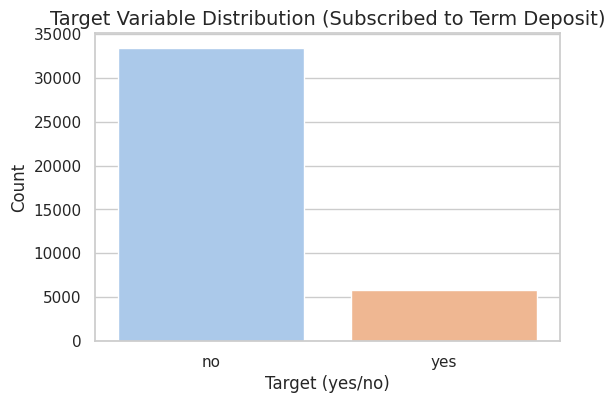

target
no     33384
yes     5827
Name: count, dtype: int64

In [14]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data, palette='pastel')
plt.title('Target Variable Distribution (Subscribed to Term Deposit)', fontsize=14)
plt.xlabel('Target (yes/no)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

train_data['target'].value_counts()

### Observations:

- Imbalance: The target variable is imbalanced. There are significantly more 'no' values (customers who did not subscribe to the term deposit) than 'yes' values (customers who did subscribe).

- Visualization: The countplot clearly shows the imbalance, with the bar for 'no' being much taller than the bar for 'yes'.

- Frequency: The value_counts() function provides the exact frequency of each cat

Summary - The class imbalance observed in the target variable might impact the performance of machine learning models trained on this data. Models might be biased towards predicting the majority class ('no') and have lower accuracy in predicting the minority class ('yes'). Techniques like oversampling or undersampling might be needed to address this imbalance.egory.ory.

In [15]:
train_data['last contact date'] = pd.to_datetime(train_data['last contact date'])
train_data['month'] = train_data['last contact date'].dt.month
train_data['year'] = train_data['last contact date'].dt.year
train_data['weekday'] = train_data['last contact date'].dt.weekday


test_data['last contact date'] = pd.to_datetime(test_data['last contact date'])
test_data['month'] = test_data['last contact date'].dt.month
test_data['year'] = test_data['last contact date'].dt.year
test_data['weekday'] = test_data['last contact date'].dt.weekday

train_data.drop(columns=['last contact date'],inplace=True)
test_data.drop(columns=['last contact date'],inplace=True)

### Observations:

- Date Conversion: The code first converts the 'last contact date' column in both train_data and test_data to datetime objects using pd.to_datetime.
- Feature Extraction: It then extracts three new features: 'month', 'year', and 'weekday' from the datetime object and adds them as separate columns.
- Original Column Removal: Finally, the original 'last contact date' column is dropped from both DataFra

Ssummary 
- Improved Model Performance: By extracting date-related features, the model might be able to capture patterns or trends associated with specific months, years, or days of the week, potentially leading to improved predictive performance.
- Feature Engineering: This step demonstrates a basic form of feature engineering, where new features are created from existing ones to enhance the dataset's information content for the model.
- Reduced Dimensionality: Although new features are added, removing the original 'last contact date' column helps to avoid redundancy and keep the dataset concise.mes.

## Month

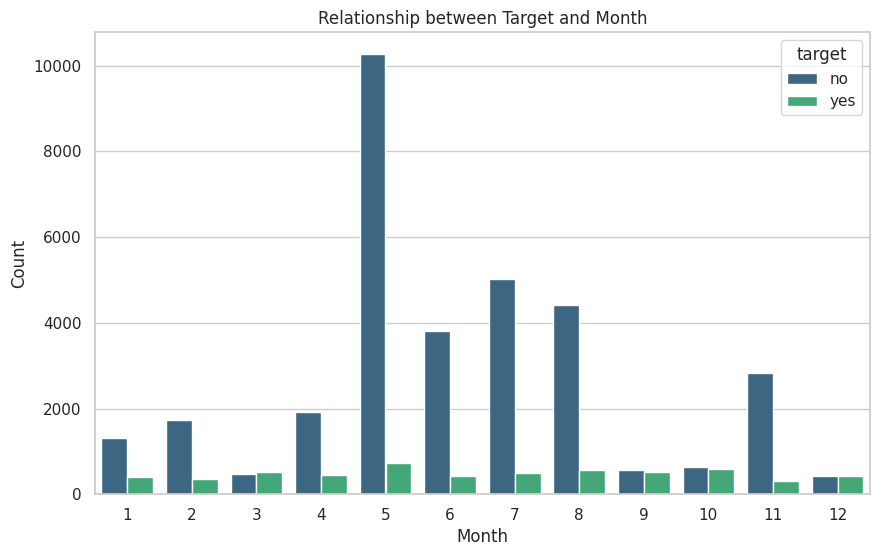

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='month', hue='target', data=train_data, palette="viridis")
plt.title('Relationship between Target and Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### Observation:
- Identifying Patterns: The visualization helps to identify potential patterns or trends in subscription behavior across different months. For example, certain months might have higher or lower subscription rates compared to others.- 
Feature Importance: If significant differences in subscription rates are observed across months, it suggests that the 'month' feature might be an important predictor for the target variable.
- 
Model Development: This insight can be used to inform feature engineering and model selection during the model development process.

## Year

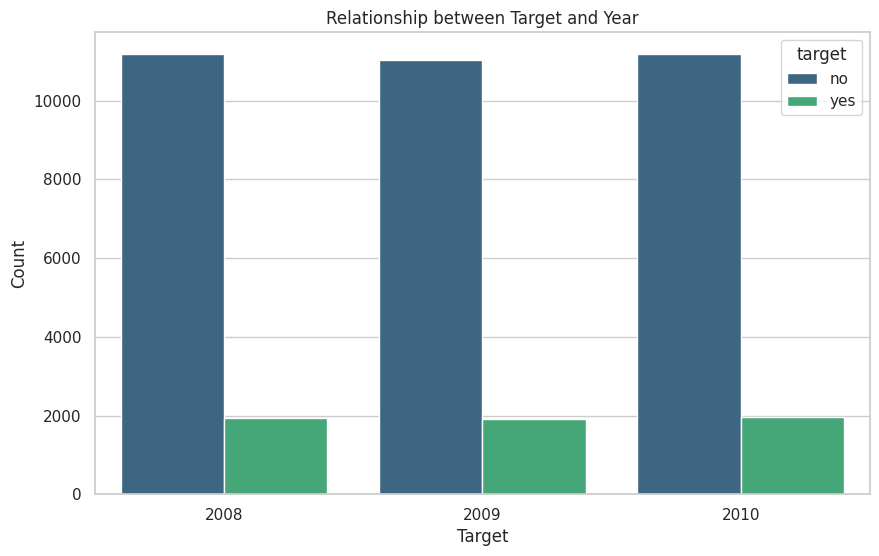

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='year', hue='target', data=train_data, palette="viridis")
plt.title('Relationship between Target and Year')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### Observations:
- Identifying Trends: The visualization helps to identify potential trends in subscription behavior across different years. For example, subscription rates might have increased or decreased over time.- 
Feature Importance: If significant differences in subscription rates are observed across years, it suggests that the 'year' feature might be an important predictor for the target variable.
- 
Model Development: This insight can be used to inform feature engineering and model selection during the model development process.
Potential Correction: The incorrect x-axis label should be corrected to 'Year' for better clarity and interpretation.

## Weekday

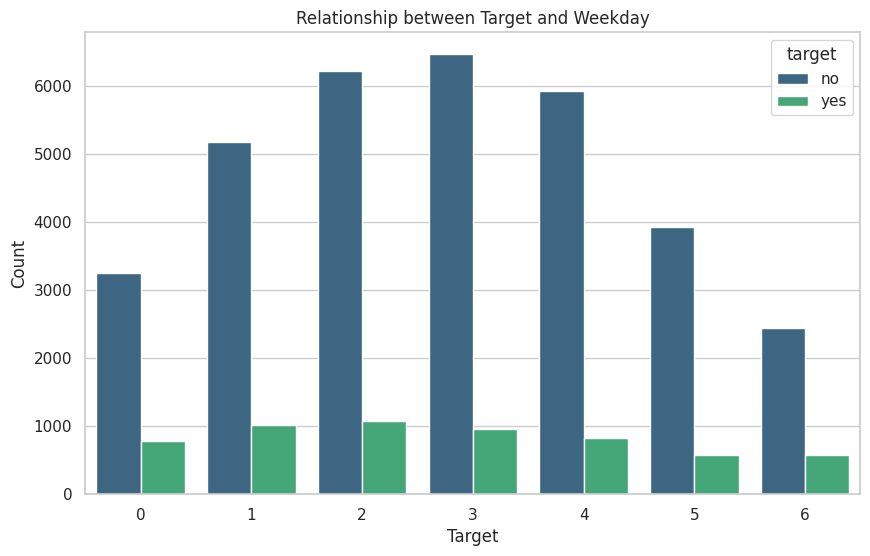

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='weekday', hue='target', data=train_data, palette="viridis")
plt.title('Relationship between Target and Weekday')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### Observations:

- Identifying Patterns: The visualization helps to identify potential patterns or trends in subscription behavior across different weekdays. For example, certain weekdays might have higher or lower subscription rates compared to others.- 
Feature Importance: If significant differences in subscription rates are observed across weekdays, it suggests that the 'weekday' feature might be an important predictor for the target variable.
- 
Model Development: This insight can be used to inform feature engineering and model selection during the model development process.
Potential Correction: The incorrect x-axis label should be corrected to 'Weekday' for better clarity and interpretation.

## Job and Target

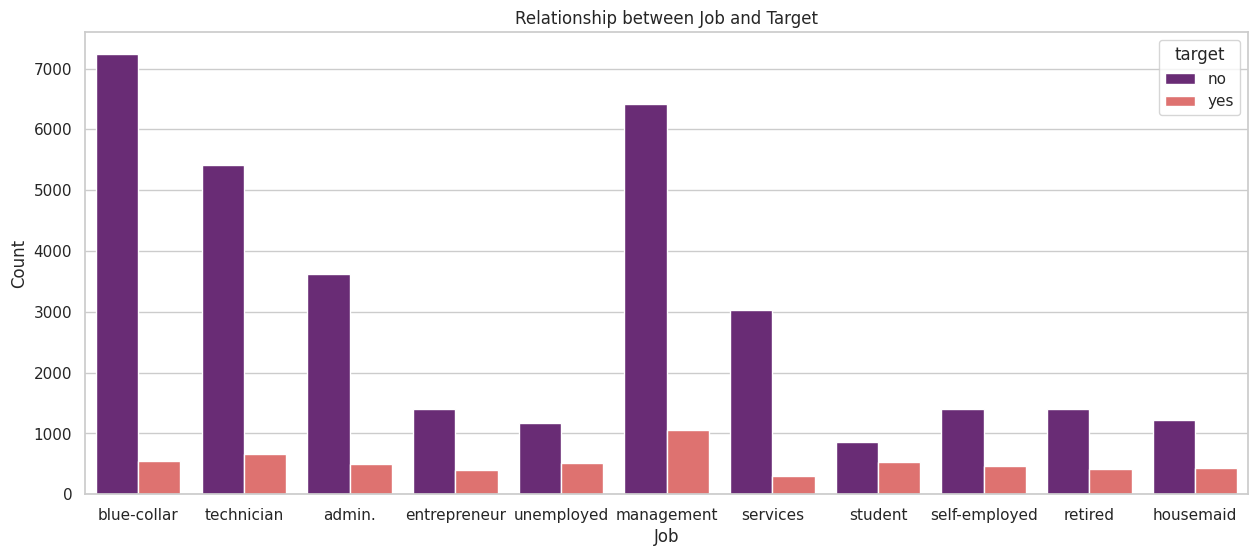

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(x='job', hue='target', data=train_data, palette="magma")
plt.title('Relationship between Job and Target')
plt.xlabel('Job')
plt.ylabel('Count')
plt.show()

### Observations:

- Identifying Patterns: The visualization aids in identifying potential patterns or trends in subscription behavior across different job categories. For example, certain jobs might show higher or lower subscription rates compared to others.- 
Feature Importance: If significant differences in subscription rates are observed across job categories, it suggests that the 'job' feature might be an important predictor for the target variable.
- 
Model Development: This insight can be used to inform feature engineering and model selection during the model development process.

## Age and Target

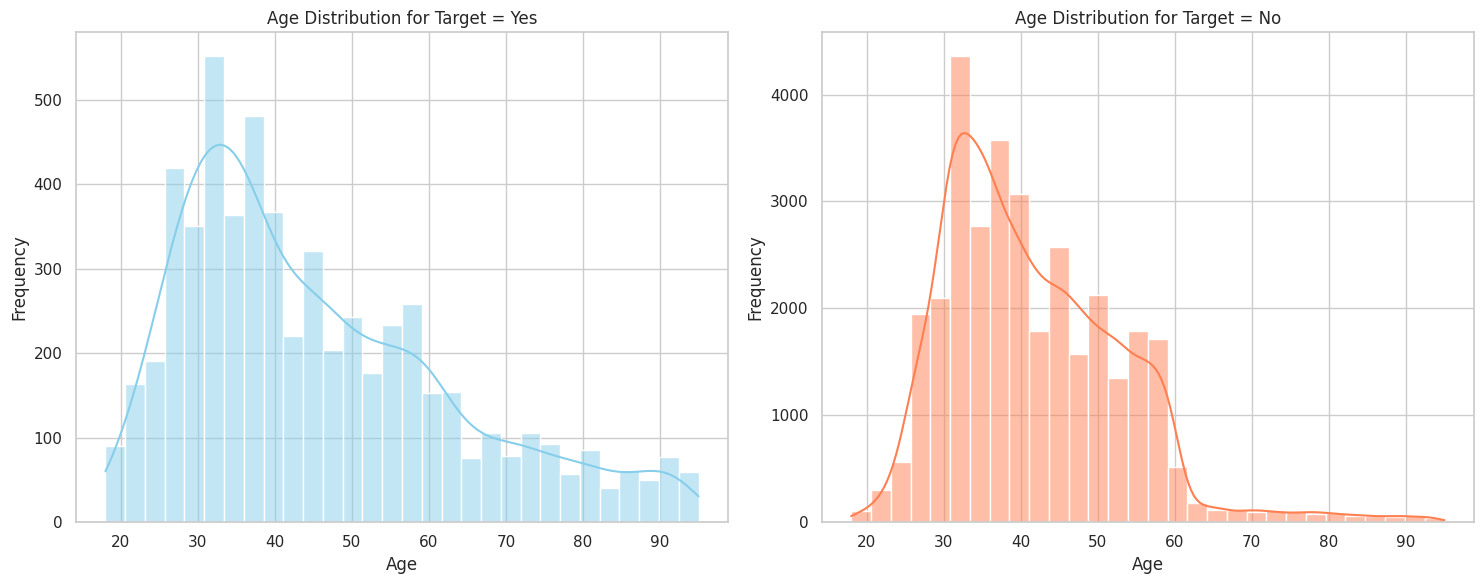

In [20]:
df = train_data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.histplot(data=df[df['target'] == 'yes'], x='age', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Age Distribution for Target = Yes')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(data=df[df['target'] == 'no'], x='age', bins=30, kde=True, color='coral', ax=axes[1])
axes[1].set_title('Age Distribution for Target = No')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)


plt.tight_layout()
plt.show()

### Observations:

- Identifying Age-Related Patterns: The histograms help to identify potential age-related patterns in subscription behavior. For example, certain age groups might be more or less likely to subscribe to term deposits.- 
Feature Importance: If significant differences in age distributions are observed between target categories, it suggests that the 'age' feature might be an important predictor for the target variable.
- 
Model Development: This insight can be used to inform feature engineering and model selection during the model development process.

## Box Plot for Numerical Columns

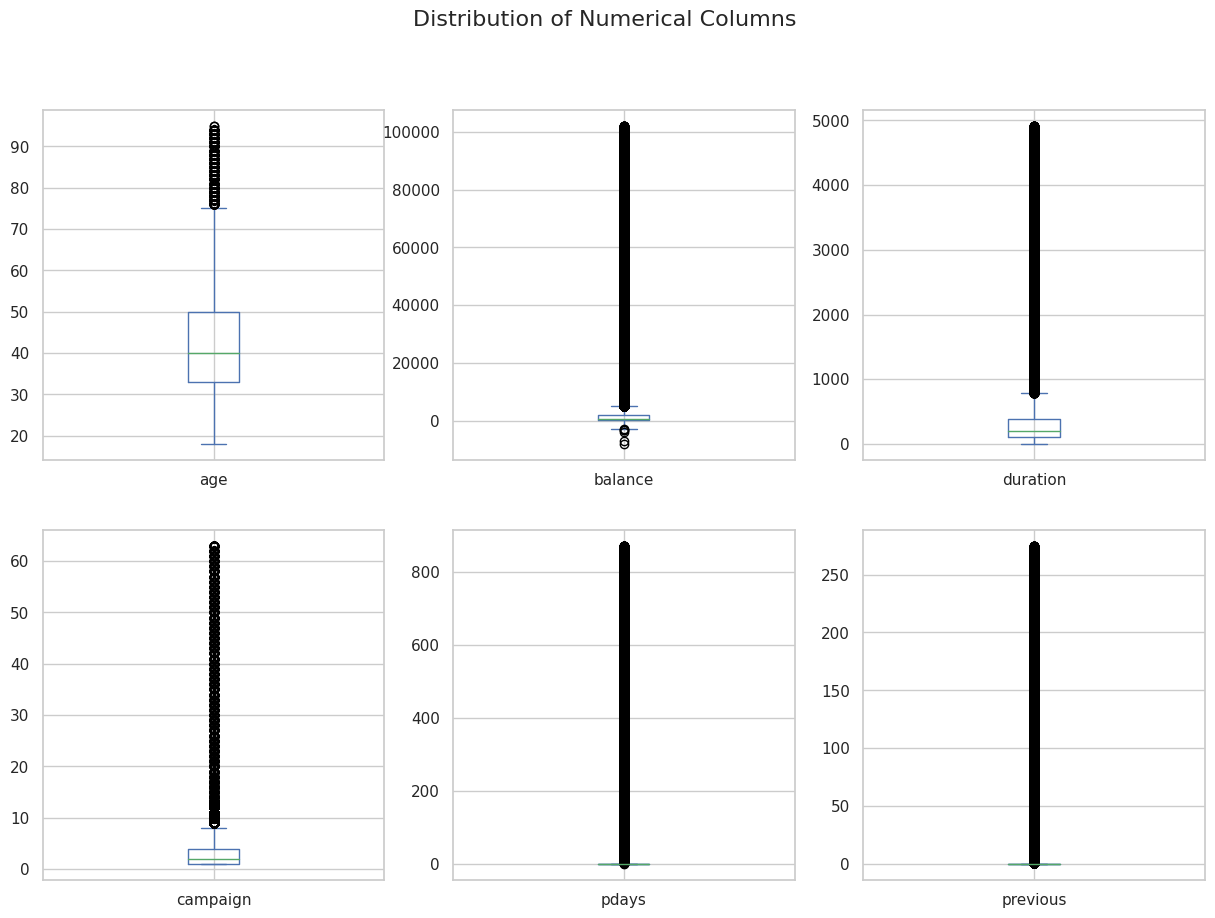

In [21]:
import matplotlib.pyplot as plt

numerical_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
train_data[numerical_columns].plot(kind='box', subplots=True, layout=(2,3), figsize=(15, 10))
plt.suptitle('Distribution of Numerical Columns', fontsize=16)
plt.show()

### Observations:

- Understanding Data Distribution: Box plots provide a visual summary of the distribution of each numerical feature, including central tendency, spread, and skewness.
- 
Identifying Outliers: Box plots highlight potential outliers, which are data points that significantly deviate from the rest of the data.
- 
Feature Scaling: The presence of outliers or significant differences in scales between numerical features might suggest the need for feature scaling before model traini.

- .
Data Preprocessing: Insights from box plots can inform data preprocessing steps like handling outliers or applying transformations to improve model performance.

## Count Plot for Categorical Columns

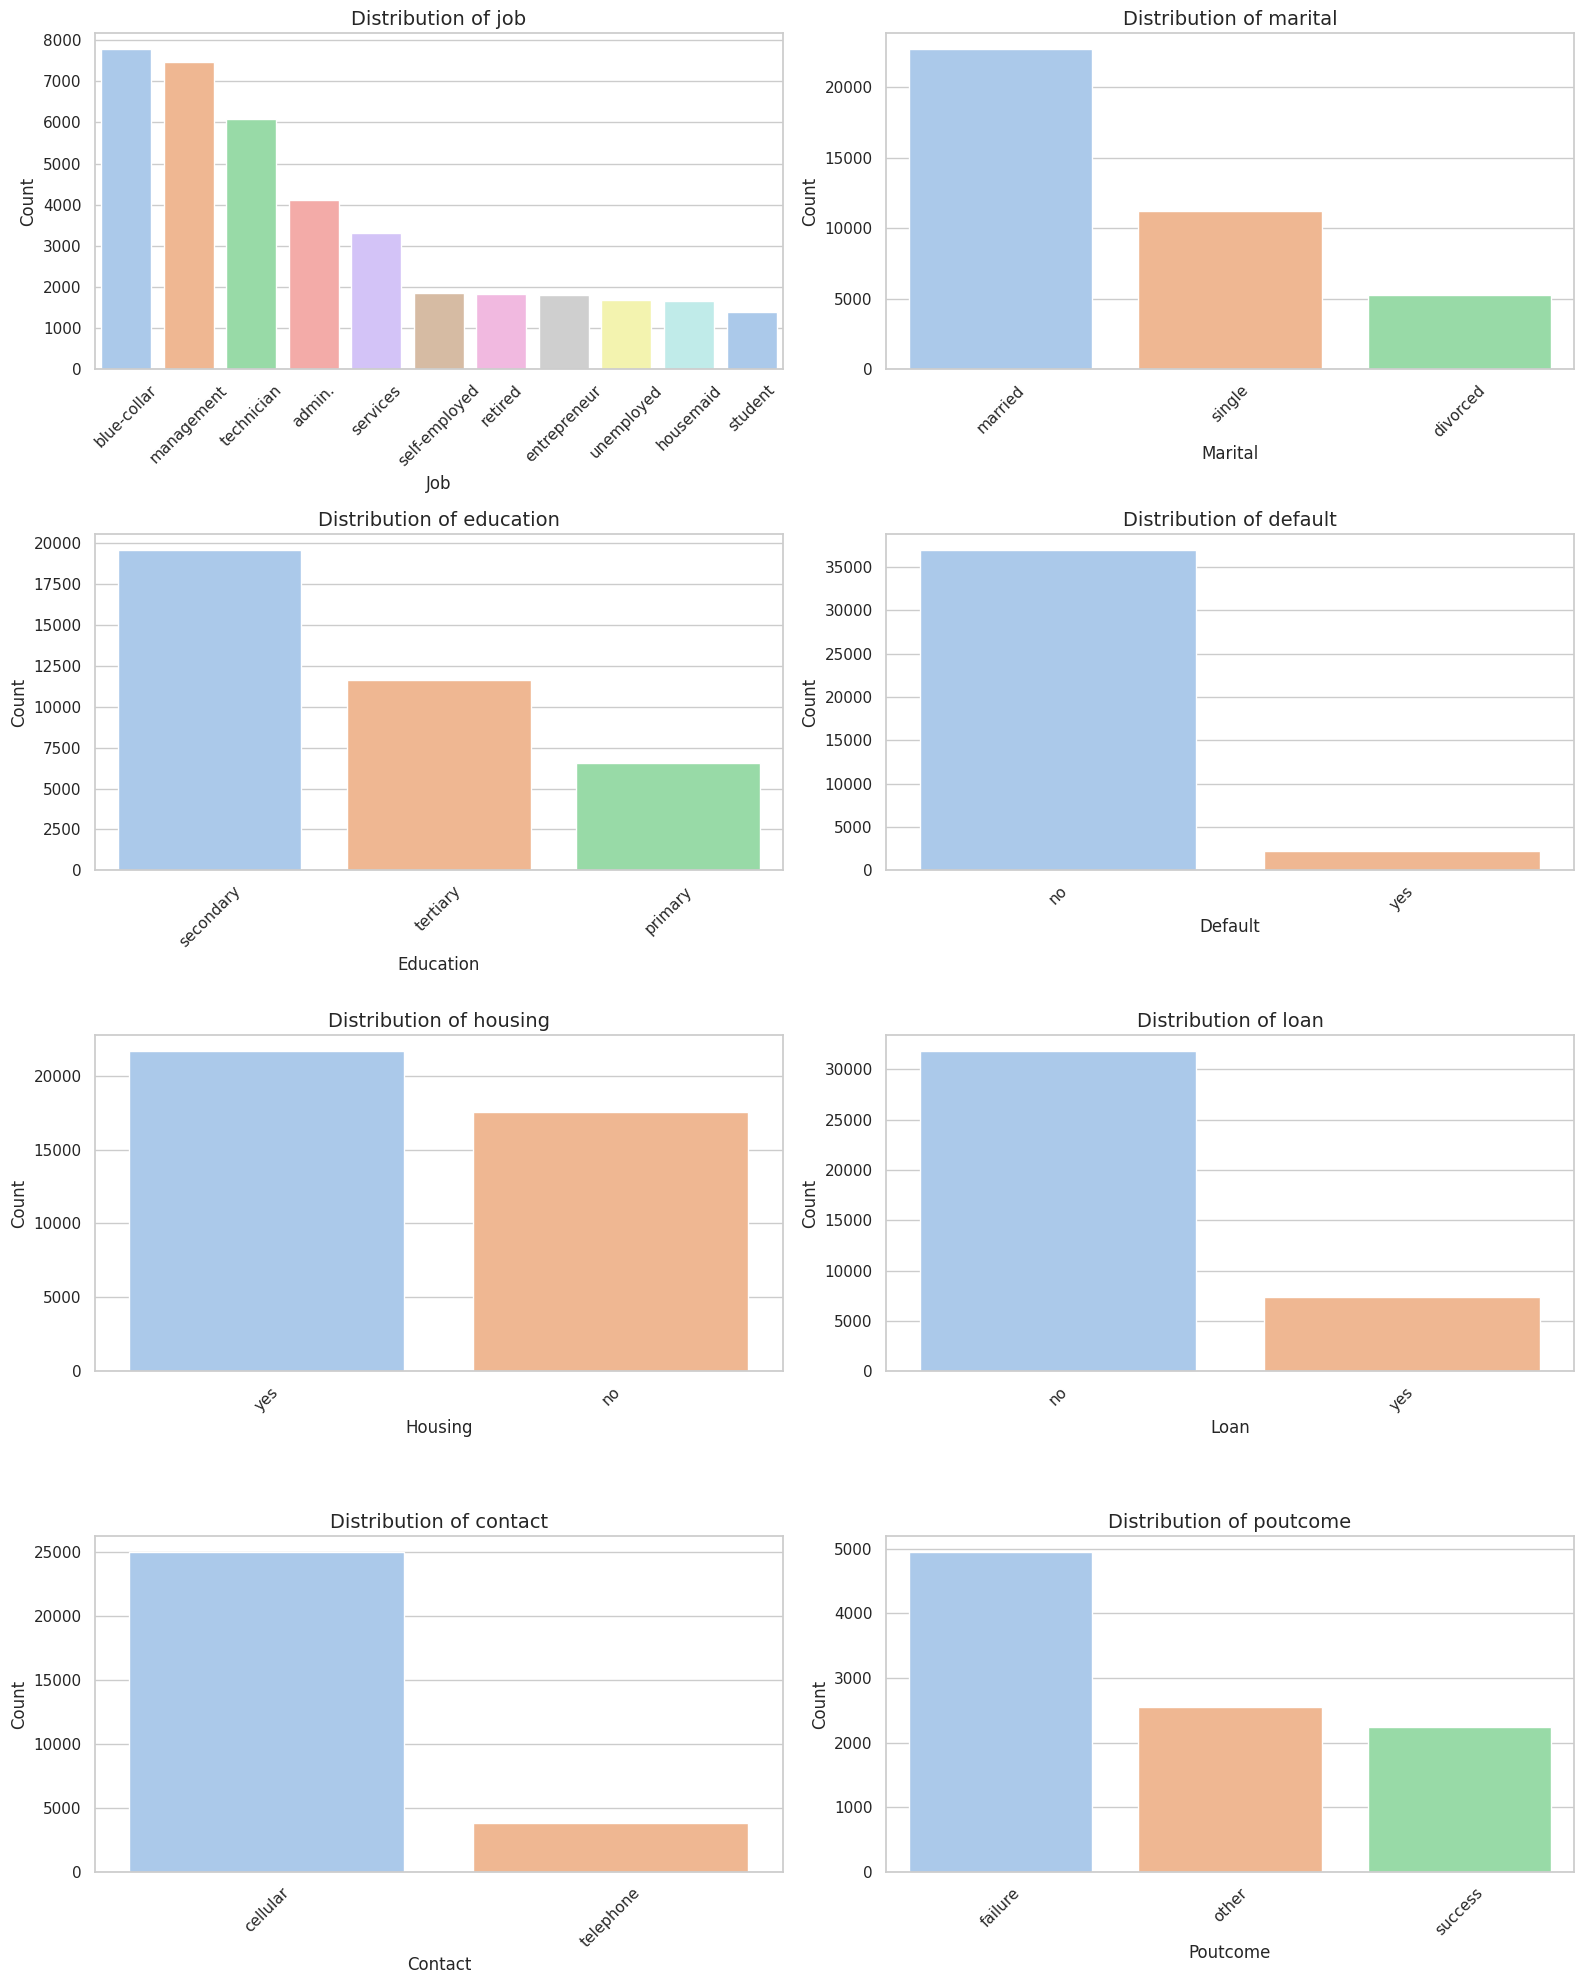

In [22]:
import warnings
warnings.filterwarnings('ignore')

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, feature in enumerate(categorical_columns):
    sns.countplot(x=feature, data=train_data, palette='pastel', ax=axes[idx], order=train_data[feature].value_counts().index)
    axes[idx].set_title(f"Distribution of {feature}", fontsize=14)
    axes[idx].set_xlabel(feature.capitalize(), fontsize=12)
    axes[idx].set_ylabel("Count", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Observations:
- Understanding Category Frequencies: Count plots provide a visual representation of the frequency of each category within categorical features.
- 
Identifying Dominant Categories: They help identify dominant or rare categories within each feature.
- 
Feature Engineering: Insights from count plots can inform feature engineering decisions, such as grouping infrequent categories or creating dummy variables
- .
Data Exploration: Count plots are valuable for initial data exploration and understanding the distribution of categorical variables.

## Correlation Matrix

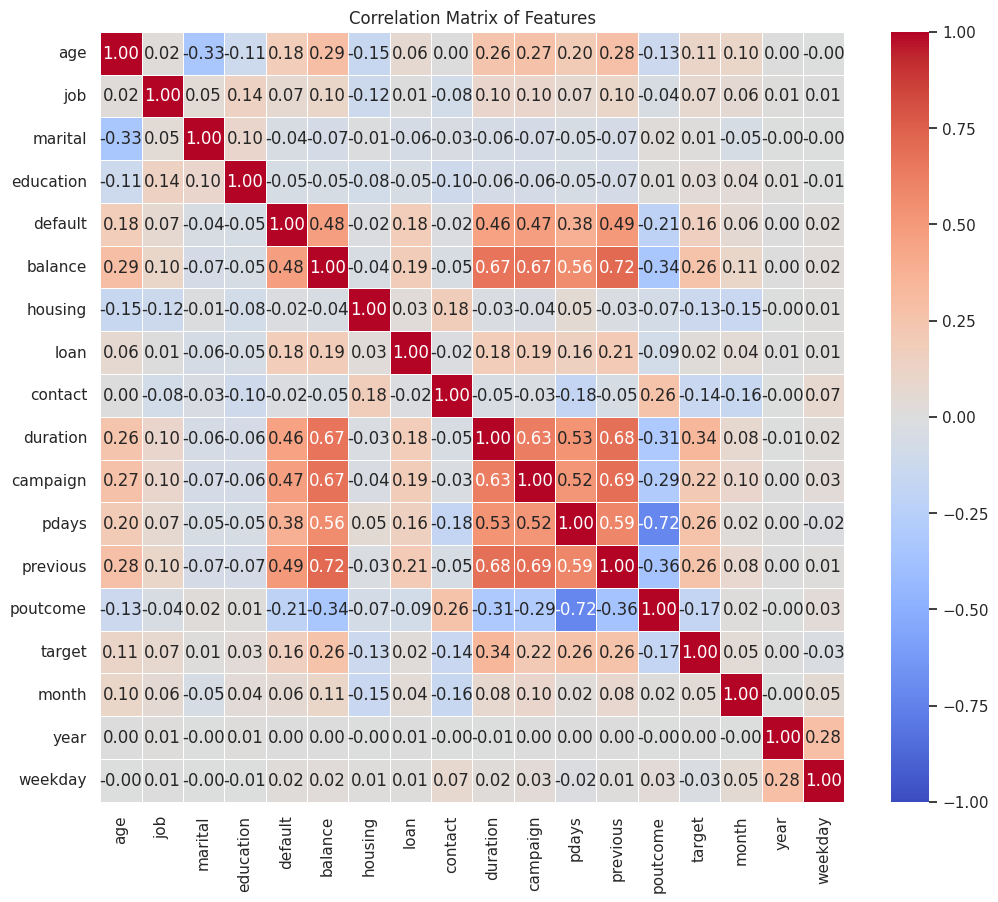

In [23]:
df_encoded = train_data.copy()

categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month']

label_encoder = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

df_encoded['target'] = label_encoder.fit_transform(df_encoded['target'])


correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

### Observations from the Heatmap:

- Correlation Strength: The heatmap uses a color scale to represent correlation strength. Darker red indicates strong positive correlations, darker blue indicates strong negative correlations, and lighter colors indicate weaker correlations.

- Target Variable Correlation: You should focus on the row or column corresponding to the 'target' variable. Observe which features have relatively stronger (positive or negative) correlations with the target. These features might be more important for predicting the target.

- Feature Intercorrelation: Look for strong correlations between predictor variables (features other than the target). High correlations (close to 1 or -1) might indicate multicollinearity, where features are redundant and provide similar information. This could potentially affect model performance.

- Notable Correlations: Some specific correlations that might stand out include:
  - Positive correlation between 'duration' and 'target', suggesting that longer call durations might be associated with higher subscription rates.
  - Negative correlation between 'housing' and 'target', indicating that customers with housing loans might be less likely to subscribe.
  - Potential correlations between other features, which you should examine based on the color intensity and annotation values in the heatmap.heatmap.

## Imputation

#### Imputation with Mode

In [24]:
X = train_data.drop(columns=['target'])
y = train_data['target']
cols = X.columns

imputer = SimpleImputer(strategy='most_frequent')

X = pd.DataFrame(imputer.fit_transform(X), columns=cols)
test_data = pd.DataFrame(imputer.transform(test_data), columns=cols)

### Observations:

- Data Separation: The code first separates the predictor variables (features) into X and the target variable into y.
- Imputer Initialization: It initializes a SimpleImputer with the strategy set to 'most_frequent'. This means that missing values will be replaced with the most frequent value (mode) of the respective column.
- Imputation on Training Data: The imputer is fitted to the training data (X) using imputer.fit_transform(), and the missing values are imputed. The result is then converted back into a pandas DataFrame.
- Imputation on Test Data: The same imputer (already fitted to the training data) is used to transform the test data (test_data) using imputer.transform(), imputing missing values with the mode from the training data. This ensures consistency in imputation between training and test 

Summary: 
- Mode imputation replaces missing values with the most frequent value (mode) in the column.
- It's suitable for categorical features, preserving their categorical nature.
- It's simple, efficient, and robust to outliers.
- It maintains the original distribution of categories.
- It's a common practice for handling missing categorical data.sets.sets.

In [25]:
X.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
month        0
year         0
weekday      0
dtype: int64

In [26]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Insights:

Here we converts the target variable (y) from categorical values (like 'yes' or 'no') into numerical labels (like 0 and 1) using Label Encoding. This is often necessary for machine learning algorithms that require numerical input.

# Train-Validation Split

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)

### Insights:

Here we do the train_test_split function from scikit-learn to split the data into training and validation sets.
- Parameters:
  - X: The predictor variables (features).
  - y: The target variable (encoded numerical labels).
  - test_size=0.7: Specifies that 70% of the data should be used for validation and 30% for training. This might seem unusual, as typically a smaller portion is used for validation. This could be a user's mistake or a specific case for this dataset.
  - random_state=42: Sets a random seed for reproducibility, ensuring that the split is consistent across different runs.
  - stratify=y: This ensures that the target variable's distribution is maintained in both the training and validation sets, which is important for imbalanced datasets.

# Data Preprocessing and Feature Engineering

In [28]:
categorical_col = ['marital','housing','loan','default','contact','education','job','poutcome','weekday','month','year']
numerical_col = ['age','previous','pdays','duration','balance','campaign']


numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_col),
        ('cat', categorical_transformer, categorical_col)
    ],
    remainder='passthrough'
)

x_train_transformed = preprocessor.fit_transform(X_train)

x_test_transformed = preprocessor.transform(X_val)
x_test_transformed_final = preprocessor.transform(test_data)

### Insights:
- Feature Separation: The code first separates features into categorical and numerical columns.
- Transformers: It then defines transformers for each type:
  - StandardScaler for numerical features: This scales numerical features to have zero mean and unit variance, which can improve model performance.
  - OneHotEncoder for categorical features: This converts categorical features into numerical representations using one-hot encoding, creating a new binary feature for each category.
- ColumnTransformer: A ColumnTransformer is used to apply the appropriate transformers to the corresponding columns.
- Fitting and Transforming:
  - fit_transform is called on the training data (X_train) to fit the transformers and transform the training data.
  - transform is called on the validation (X_val) and test (test_data) data to apply the fitted transformers without refitting.

Summary:
- Improved Model Performance: Feature scaling and encoding can significantly improve the performance of many machine learning models.
- Preventing Bias: Consistent transformations across datasets prevent introducing bias into the model.
- Algorithm Compatibility: The transformed data is compatible with a wider range of machine learning algorithms.

## Feature Selection
### 
Recursive Feature Elimination (RFE)

In [29]:
from sklearn.feature_selection import SelectFromModel

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train_transformed, y_train)


selector = SelectFromModel(estimator=model, threshold="mean")
x_train_selected = selector.fit_transform(x_train_transformed, y_train)
x_test_selected = selector.transform(x_test_transformed)
x_test_transformed_final_selected = selector.transform(x_test_transformed_final)

selected_indices = selector.get_support(indices=True)

feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_col)) + numerical_col

selected_feature_names = [feature_names[i] for i in selected_indices]

print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['marital_divorced', 'marital_married', 'marital_single', 'housing_no', 'housing_yes', 'loan_no', 'weekday_3', 'weekday_5']


### Observations:

- Model for Feature Importance: A Random Forest Classifier (RandomForestClassifier) is used to estimate feature importance.
- Feature Selection with RFE: SelectFromModel is used with the Random Forest model to select features based on their importance.
- Threshold: The threshold="mean" parameter selects features with importance scores above the mean importance.
- Transforming Data: The selected features are used to transform the training, validation, and test data.
- Getting Selected Feature Names: The code retrieves the names of the selected features.


Summary:
- Improved Model Performance: By selecting relevant features, the model might become more accurate and efficient.
- Reduced Overfitting: Feature selection can help to prevent overfitting by removing irrelevant or redundant features.
- Model Interpretability: Using fewer features can make the model easier to interpret and understand.tures.

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif

selector_f_classif = SelectKBest(score_func=f_classif, k='all')
x_train_selected_f_classif = selector_f_classif.fit_transform(x_train_transformed, y_train)
x_test_selected_f_classif = selector_f_classif.transform(x_test_transformed)
x_test_transformed_final_f_classif = selector_f_classif.transform(x_test_transformed_final)


selected_indices_f_classif = selector_f_classif.get_support(indices=True)


feature_names = list(preprocessor.get_feature_names_out())
selected_features_f_classif = [feature_names[i] for i in selected_indices_f_classif]

print("Selected Features using f_classif:", selected_features_f_classif)

Selected Features using f_classif: ['num__age', 'num__previous', 'num__pdays', 'num__duration', 'num__balance', 'num__campaign', 'cat__marital_divorced', 'cat__marital_married', 'cat__marital_single', 'cat__housing_no', 'cat__housing_yes', 'cat__loan_no', 'cat__loan_yes', 'cat__default_no', 'cat__default_yes', 'cat__contact_cellular', 'cat__contact_telephone', 'cat__education_primary', 'cat__education_secondary', 'cat__education_tertiary', 'cat__job_admin.', 'cat__job_blue-collar', 'cat__job_entrepreneur', 'cat__job_housemaid', 'cat__job_management', 'cat__job_retired', 'cat__job_self-employed', 'cat__job_services', 'cat__job_student', 'cat__job_technician', 'cat__job_unemployed', 'cat__poutcome_failure', 'cat__poutcome_other', 'cat__poutcome_success', 'cat__weekday_0', 'cat__weekday_1', 'cat__weekday_2', 'cat__weekday_3', 'cat__weekday_4', 'cat__weekday_5', 'cat__weekday_6', 'cat__month_1', 'cat__month_2', 'cat__month_3', 'cat__month_4', 'cat__month_5', 'cat__month_6', 'cat__month_7',

### Insights:
selects all features most relevant to the target variable using a statistical method called ANOVA F-value. This feature selection aims to improve model performance, reduce overfitting, and increase computational efficiency by using only the most important features for model training.

# Model Training

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train_selected_f_classif, y_train)


y_pred = model.predict(x_test_selected_f_classif)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (Logistic Regression with f_classif): {accuracy}")

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, target_names=['no', 'yes']))

Accuracy on validation set (Logistic Regression with f_classif): 0.8587510929758088
              precision    recall  f1-score   support

          no       0.88      0.97      0.92     23369
         yes       0.56      0.22      0.31      4079

    accuracy                           0.86     27448
   macro avg       0.72      0.59      0.62     27448
weighted avg       0.83      0.86      0.83     27448



### Insights:

The accuracy score is calculated and printed, indicating the proportion of correctly classified instances in the validation set. This gives an overall measure of the model's performance. And The classification report provides detailed metrics such as precision, recall, F1-score, and support for each class ('no' and 'yes'). This helps to understand the model's performance for each class separately.

## XGBoost

In [32]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(x_train_selected_f_classif, y_train)

xgb_y_pred = xgb_model.predict(x_test_selected_f_classif)

xgb_accuracy = accuracy_score(y_val, xgb_y_pred)
print(f"Accuracy on validation set (XGBoost with f_classif): {xgb_accuracy}")

print(classification_report(y_val, xgb_y_pred, target_names=['no', 'yes']))

Accuracy on validation set (XGBoost with f_classif): 0.8663290585835034
              precision    recall  f1-score   support

          no       0.91      0.94      0.92     23369
         yes       0.56      0.46      0.50      4079

    accuracy                           0.87     27448
   macro avg       0.74      0.70      0.71     27448
weighted avg       0.86      0.87      0.86     27448



### Insights:

The classification report shows how well the model performs in predicting each class. If the dataset is imbalanced, focusing on metrics like precision, recall, and F1-score for the minority class is important.Comparing the XGBoost model's performance with the previous Logistic Regression model's performance can help determine which model is better suited for the task.

## Randomforest

In [33]:
# Initialize and train the random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train_selected_f_classif, y_train)


rf_y_pred = rf_model.predict(x_test_selected_f_classif)

rf_accuracy = accuracy_score(y_val, rf_y_pred)
print(f"Accuracy on validation set (Random Forest with f_classif): {rf_accuracy}")


print(classification_report(y_val, rf_y_pred, target_names=['no', 'yes']))

Accuracy on validation set (Random Forest with f_classif): 0.8683328475663072
              precision    recall  f1-score   support

          no       0.89      0.96      0.93     23369
         yes       0.60      0.35      0.44      4079

    accuracy                           0.87     27448
   macro avg       0.75      0.65      0.68     27448
weighted avg       0.85      0.87      0.85     27448



### Insights:

The classification report shows how well the model performs in predicting each class. If the dataset is imbalanced, focusing on metrics like precision, recall, and F1-score for the minority class is important.Comparing the Random Forest model's performance with the previous Logistic Regression model's and XGBoost model's performance can help determine which model is better suited for the task.

# HyperParameter Tunning

## Logistic regression HyperParameter Tunning

In [34]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logreg = LogisticRegression(max_iter=1000, random_state=42)


grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=5)


grid_search.fit(x_train_selected_f_classif, y_train)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


best_logreg = grid_search.best_estimator_


y_pred = best_logreg.predict(x_test_selected_f_classif)


accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (Tuned Logistic Regression): {accuracy}")
print(classification_report(y_val, y_pred, target_names=['no', 'yes']))

Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.8595605624315175
Accuracy on validation set (Tuned Logistic Regression): 0.8586417953949286
              precision    recall  f1-score   support

          no       0.88      0.97      0.92     23369
         yes       0.56      0.22      0.32      4079

    accuracy                           0.86     27448
   macro avg       0.72      0.59      0.62     27448
weighted avg       0.83      0.86      0.83     27448



## Random forest HyperParameter Tunning

In [35]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(x_train_selected_f_classif, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


best_rf_model = grid_search.best_estimator_


y_pred = best_rf_model.predict(x_test_selected_f_classif)


accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (Tuned Random Forest): {accuracy}")
print(classification_report(y_val, y_pred, target_names=['no', 'yes']))

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.8683166084113203
Accuracy on validation set (Tuned Random Forest): 0.8689522005246284
              precision    recall  f1-score   support

          no       0.89      0.96      0.93     23369
         yes       0.60      0.34      0.44      4079

    accuracy                           0.87     27448
   macro avg       0.75      0.65      0.68     27448
weighted avg       0.85      0.87      0.85     27448



## XGBoost HyperParameter Tunning

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(x_train_selected_f_classif, y_train)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


best_xgb_model = grid_search.best_estimator_


y_pred = best_xgb_model.predict(x_test_selected_f_classif)


accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (Tuned XGBoost): {accuracy}")
print(classification_report(y_val, y_pred, target_names=['no', 'yes']))

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best Score: 0.869251729591114
Accuracy on validation set (Tuned XGBoost): 0.8697172835907898
              precision    recall  f1-score   support

          no       0.91      0.94      0.93     23369
         yes       0.58      0.44      0.50      4079

    accuracy                           0.87     27448
   macro avg       0.74      0.69      0.71     27448
weighted avg       0.86      0.87      0.86     27448



# Model Evaluation

## Logistic Regression

Accuracy: 0.8697172835907898
ROC AUC: 0.8264963198323126
F1 Score: 0.5030572540300167
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93     23369
           1       0.58      0.44      0.50      4079

    accuracy                           0.87     27448
   macro avg       0.74      0.69      0.71     27448
weighted avg       0.86      0.87      0.86     27448



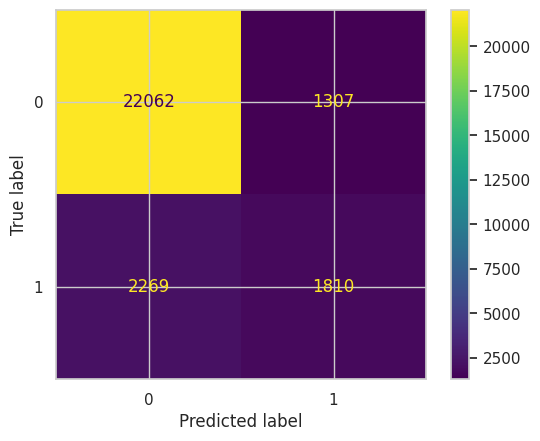

In [37]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict_proba(x_test_selected_f_classif)[:, 1]


accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"F1 Score: {f1}")
print("Classification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## Random Forest

Random Forest Accuracy: 0.8683328475663072
Random Forest ROC AUC: 0.901121408810844
Random Forest F1 Score: 0.43899410121080407
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.93     23369
           1       0.60      0.35      0.44      4079

    accuracy                           0.87     27448
   macro avg       0.75      0.65      0.68     27448
weighted avg       0.85      0.87      0.85     27448



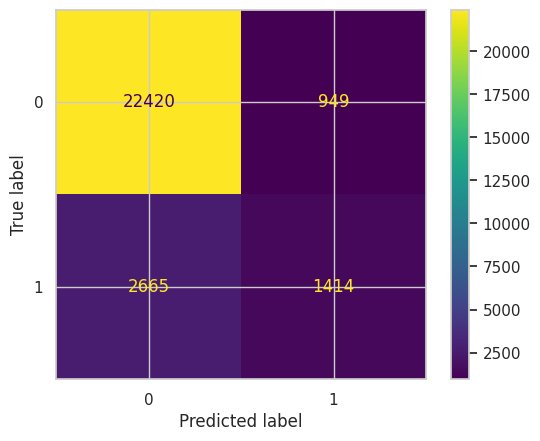

In [38]:

rf_y_pred_prob = rf_model.predict_proba(x_test_selected_f_classif)[:, 1]

rf_accuracy = accuracy_score(y_val, rf_y_pred)
rf_roc_auc = roc_auc_score(y_val, rf_y_pred_prob)
rf_f1 = f1_score(y_val, rf_y_pred)
rf_cm = confusion_matrix(y_val, rf_y_pred)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest ROC AUC: {rf_roc_auc}")
print(f"Random Forest F1 Score: {rf_f1}")
print("Random Forest Classification Report:\n", classification_report(y_val, rf_y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

## XGB

Accuracy: 0.8697172835907898
ROC AUC Score: 0.901694570446695
F1 Score: 0.5030572540300167
              precision    recall  f1-score   support

          no       0.91      0.94      0.93     23369
         yes       0.58      0.44      0.50      4079

    accuracy                           0.87     27448
   macro avg       0.74      0.69      0.71     27448
weighted avg       0.86      0.87      0.86     27448



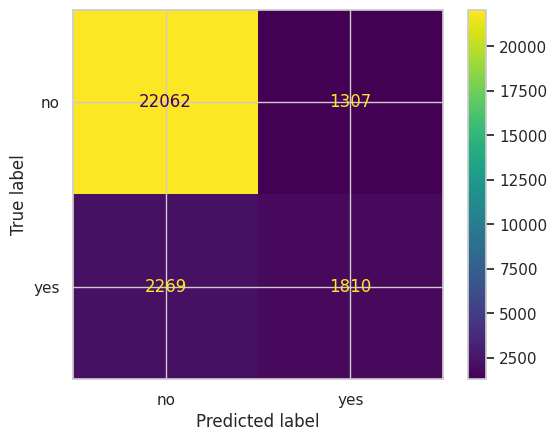

In [39]:
y_pred_prob = best_xgb_model.predict_proba(x_test_selected_f_classif)[:, 1]
y_pred = best_xgb_model.predict(x_test_selected_f_classif)


accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1}")


print(classification_report(y_val, y_pred, target_names=['no', 'yes']))

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()
plt.show()

# Model Comparision

--- Logistic Regression ---
Accuracy: 0.8587510929758088
F1 Macro Score: 0.6177187325106175
              precision    recall  f1-score   support

          no       0.88      0.97      0.92     23369
         yes       0.56      0.22      0.31      4079

    accuracy                           0.86     27448
   macro avg       0.72      0.59      0.62     27448
weighted avg       0.83      0.86      0.83     27448

--------------------
--- Random Forest ---
Accuracy: 0.8683328475663072
F1 Macro Score: 0.6822039478687858
              precision    recall  f1-score   support

          no       0.89      0.96      0.93     23369
         yes       0.60      0.35      0.44      4079

    accuracy                           0.87     27448
   macro avg       0.75      0.65      0.68     27448
weighted avg       0.85      0.87      0.85     27448

--------------------
--- XGBoost ---
Accuracy: 0.8663290585835034
F1 Macro Score: 0.7129132852735451
              precision    recall  f1-score   

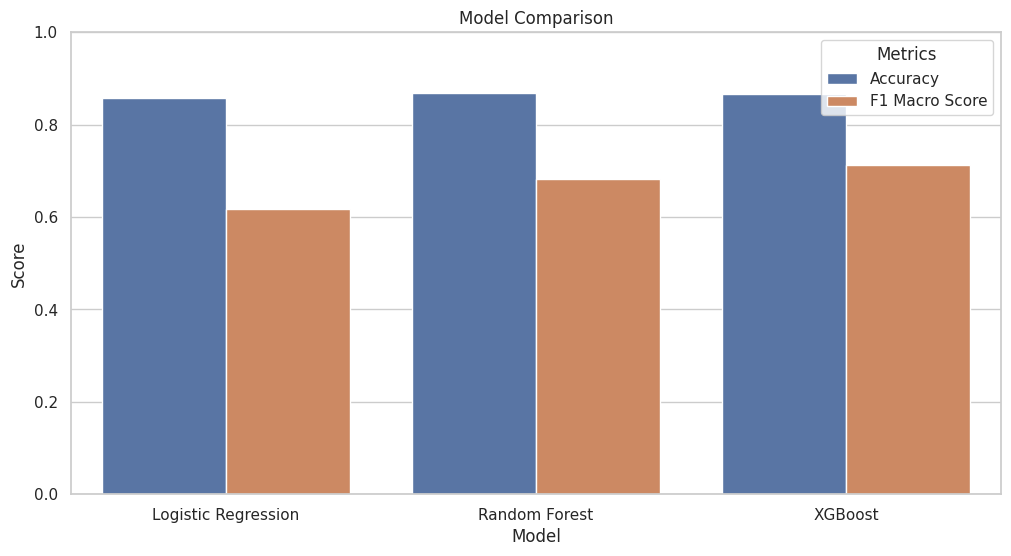

In [40]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

metrics = {'Model': [], 'Accuracy': [], 'F1 Macro Score': []}

for model_name, model in models.items():
    model.fit(x_train_selected_f_classif, y_train)
    y_pred = model.predict(x_test_selected_f_classif)
    
    accuracy = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy)
    metrics['F1 Macro Score'].append(f1_macro)
    
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Macro Score: {f1_macro}")
    print(classification_report(y_val, y_pred, target_names=['no', 'yes']))
    print("-" * 20)

metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(title='Metrics')
plt.show()

# Final Submission

In [41]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_col),
        ('cat', categorical_transformer, categorical_col)
    ],
    remainder='passthrough'
)


x_train_final = preprocessor.fit_transform(X_train)

x_val_final = preprocessor.transform(X_val)
x_test_final = preprocessor.transform(test_data)

In [42]:
final_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=5,  
    n_estimators=100, 
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

final_model.fit(x_train_final, y_train)

probs = final_model.predict_proba(x_test_final)[:, 1]

best_threshold = 0.5
preds = (probs >= best_threshold).astype(int)

## Create submission file

In [43]:
sample_submission['target'] = ['yes' if pred == 1 else 'no' for pred in preds] 
sample_submission.to_csv('submission.csv', index=False)
print("Submission file created: 'submission.csv'")

Submission file created: 'submission.csv'
